# Fourier Transform Based Outlier Detection in Time Series data using CuPy and CLX libraries

## Authors:
   Gorkem Batmaz (Nvidia)

## Contents

* Introduction
* Implementation using CuPy and CLX
* References

## Introduction

Outlier detection is a  technique for detecting outliers in the observed data or in time series. In real life, signals of interest can have many sinusoidal components and a lot of noise. Therefore it is not always straightforward to create rules to catch anomalies. We will demonstrate how we can detect outliers in time series data using Fourier transform.
We quote from -Brighan, 1974, The FFT- "..., the essence of the Fourier Transform of a waveform is to decompose or separate the waveform into a sum of sinusoids of different frequencies. If these sinusoids sum to the original waveform then we have determined the Fourier Transform of the waveform." Mathematically, this transform is stated as:

$X(\omega)=\int_{-\infty}^{\infty} x(t) e^{-t \omega t} d t$

We will use discrete Fourier transform for performing Fourier analysis of discrete-time sequences. It will help us denoise the signal and allow us to employ statistical methods to detect anomalies.

The Discrete Fourier Transform $ X[k] $ of $ x[n] $ is the discrete-time signal is  

$ X[k]=\sum_{k=0}^{N−1} x[n].e^{−J.2pi.kn/N} $

where $ x[n] $ is a discrete-time signal with Period N.

The Inverse Discrete Fourier transform is

$ x[n]=(1/N)\sum_{k=0}^{N−1} X[k].e^{J.2pi.kn/N} $

To do this, we will first move the signal into the frequency domain. Then we will apply kind of a filter to remove components that have too high frequencies. Once we have a more precise signal, it will be possible to use techniques such as rolling z score to detect anomalies.
In this notebook, we will use an alternative dataset not to disclose internal information. We will use a dataset of daily minimum temperature measurements taken in Melbourne, Australia between 1981 and 1990. This dataset is available to download at https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne

### Implementation

#### Importing the libraries

In [1]:
import cupy as cp
import cudf
try:
    import clx 
except ImportError:
    !conda install -c rapidsai -y clx
    import clx 
from clx.analytics.stats import rzscore
import numpy as np
try:
    import matplotlib as pyplot
except ImportError:
    !conda install -c rapidsai -y matplotlib
import matplotlib.pyplot as pyplot

try:
    import cuxfilter
except ModuleNotFoundError:
    os.system('conda install -c rapidsai -y cuxfilter')   
import cuxfilter
from cuxfilter.charts import scatter, bokeh, line
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.assets.custom_tiles import get_provider, Vendors
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis, Category20c

#### Read the data into GPU memory

In [2]:
gdf=cudf.read_csv("daily-min-temperatures.txt")

In [3]:
gdf['Temp']

0       20.7
1       17.9
2       18.8
3       14.6
4       15.8
        ... 
3645    14.0
3646    13.6
3647    13.5
3648    15.7
3649    13.0
Name: Temp, Length: 3650, dtype: float64

#### Convert cudf series into CuPy to utilise the Fast Fourier Transform functions

In [4]:
a = cp.fromDlpack(gdf['Temp'].to_dlpack())

In [5]:
a

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

#### Visualise the data

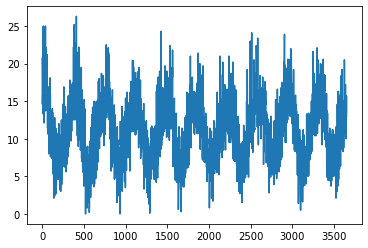

In [6]:
pyplot.plot(cp.asnumpy(a))

We can also now visualize our data using the `cuxfilter` library.

In [7]:
reshaped_df = cudf.DataFrame(a)
reshaped_df = reshaped_df.reset_index()
print(reshaped_df)

      index     0
0         0  20.7
1         1  17.9
2         2  18.8
3         3  14.6
4         4  15.8
...     ...   ...
3645   3645  14.0
3646   3646  13.6
3647   3647  13.5
3648   3648  15.7
3649   3649  13.0

[3650 rows x 2 columns]


In [8]:
reshaped_df.columns =['x' , 'y']
print(reshaped_df)

         x     y
0        0  20.7
1        1  17.9
2        2  18.8
3        3  14.6
4        4  15.8
...    ...   ...
3645  3645  14.0
3646  3646  13.6
3647  3647  13.5
3648  3648  15.7
3649  3649  13.0

[3650 rows x 2 columns]


In [9]:
demo_red_blue_palette = [ "#3182bd", "#6baed6", "#7b8ed8", "#e26798", "#ff0068" , "#323232" ]

cux_df = DataFrame.from_dataframe(reshaped_df)

line_chart_1 = line(x='x',y='y')

d = cux_df.dashboard([line_chart_1], title="")
line_chart_1.view()

Card(sizing_mode='stretch_both', title='x', width=400)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=3649, sizing_mode='scale_width', step=1, value=(0, 3649), value_throttled=(0, 3649), width=400)

The raw signal seems to have multiple components, yet it's noisy, and it's not straightforward to detect any outliers.

#### Transfer the data to the Frequency domain

There is a very efficient algorithm to calculate the DFT called FFT. We quote from -MULGREW, 1997, DSP- "The FFT is based on the observation that there are many symmetries in the DFT matrix and that many multiplications were being needlessly repeated."  The equation changes into: 

$\begin{aligned} X(k) &=\sum_{n=0}^{N-1} x(n) W_{M}^{k n}, \quad k=0,1, \ldots, N-1 \\ &=\sum_{n \text { even }} x(n) W_{N}^{k n}+\sum_{n \text { odd }} x(n) W_{M}^{k x} \\ &=\sum_{m=0}^{(M / 2)-1} x(2 m) W_{M}^{2 m k}+\sum_{m=0}^{(M / 2)-1} x(2 m+1) W_{M}^{k(2 m+1)} \end{aligned}$

Because we are computing the one dimensional discrete Fourier Transform of a real-valued signal, we can use a function called `rfft` in CuPy 

In [10]:
rft= cp.fft.rfft(a)

Setting the first 15 frequencies to zero was enough to clean our signal when we applied the inverse the Fast Fourier Transform. This number needs to be adjusted with other datasets.

In [11]:
freq_num=15

In [12]:
rft[freq_num:] = 0
y_smooth = cp.fft.irfft(rft)

In [13]:
y_smooth

array([16.13184904, 16.15809865, 16.18304895, ..., 16.04538145,
       16.07548236, 16.10430765])

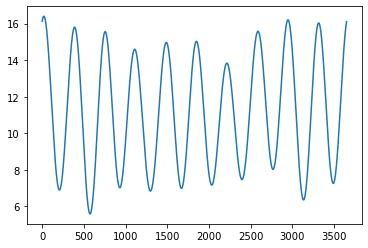

In [14]:
pyplot.plot(cp.asnumpy(y_smooth))

We can also now visualize our data using the `cuxfilter` library.

In [15]:
reshaped_df = cudf.DataFrame(y_smooth)
reshaped_df = reshaped_df.reset_index()
print(reshaped_df)

      index          0
0         0  16.131849
1         1  16.158099
2         2  16.183049
3         3  16.206693
4         4  16.229024
...     ...        ...
3645   3645  15.981388
3646   3646  16.014014
3647   3647  16.045381
3648   3648  16.075482
3649   3649  16.104308

[3650 rows x 2 columns]


In [16]:
reshaped_df.columns =['x' , 'y']
print(reshaped_df)

         x          y
0        0  16.131849
1        1  16.158099
2        2  16.183049
3        3  16.206693
4        4  16.229024
...    ...        ...
3645  3645  15.981388
3646  3646  16.014014
3647  3647  16.045381
3648  3648  16.075482
3649  3649  16.104308

[3650 rows x 2 columns]


In [17]:
cux_df = DataFrame.from_dataframe(reshaped_df)

line_chart_2 = line(x='x',y='y')

d = cux_df.dashboard([line_chart_2])
line_chart_2.view()

Card(sizing_mode='stretch_both', title='x', width=400)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=3649, sizing_mode='scale_width', step=1, value=(0, 3649), value_throttled=(0, 3649), width=400)

In [18]:
a

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

We calculate the difference between the new smooth signal and the original.

In [19]:
err=(abs(y_smooth-a))

Convert the data into a cudf series so that we can use the clx analytics library to calculate the rolling Z-score

We select rolling window as 5. This should be adjusted for other datasets.

In [20]:
rwindow=5

In [21]:
rz=rzscore(cudf.Series(cp.ascontiguousarray((err))),rwindow)[rwindow-1:] #Remove the NA rows

In [22]:
rz

4      -1.280745
5      -1.101274
6      -0.737006
7       0.631617
8       1.982907
          ...   
3645   -0.526520
3646   -0.325860
3647    0.507178
3648   -1.702751
3649    1.101080
Length: 3646, dtype: float64

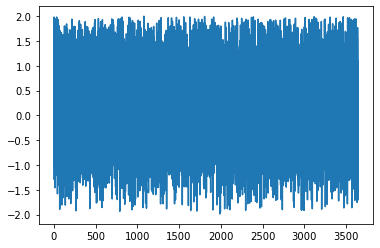

In [23]:
pyplot.plot(cp.asnumpy(cp.asarray(rz)))

We can now visualize our data using the `cuxfilter` library.

In [24]:
reshaped_df = cudf.DataFrame(cp.asarray(rz))
reshaped_df = reshaped_df.reset_index()
print(reshaped_df)

      index         0
0         0 -1.280745
1         1 -1.101274
2         2 -0.737006
3         3  0.631617
4         4  1.982907
...     ...       ...
3641   3641 -0.526520
3642   3642 -0.325860
3643   3643  0.507178
3644   3644 -1.702751
3645   3645  1.101080

[3646 rows x 2 columns]


In [25]:
reshaped_df.columns =['x' , 'y']
print(reshaped_df)

         x         y
0        0 -1.280745
1        1 -1.101274
2        2 -0.737006
3        3  0.631617
4        4  1.982907
...    ...       ...
3641  3641 -0.526520
3642  3642 -0.325860
3643  3643  0.507178
3644  3644 -1.702751
3645  3645  1.101080

[3646 rows x 2 columns]


In [26]:
cux_df = DataFrame.from_dataframe(reshaped_df)

line_chart_3 = line(x='x',y='y')

d = cux_df.dashboard([line_chart_3])
line_chart_3.view()

Card(sizing_mode='stretch_both', title='x', width=400)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=3645, sizing_mode='scale_width', step=1, value=(0, 3645), value_throttled=(0, 3645), width=400)

In this plot, we can see that the rolling Z-scores mostly vary between -2 and 2. This view may help us select a threshold.

Convert the data back into a CuPy array

In [27]:
rzn=cp.fromDlpack(rz.to_dlpack())

In [28]:
rzn

array([-1.28074544, -1.10127388, -0.73700588, ...,  0.50717802,
       -1.70275054,  1.10107965])

#### Select a rolling z score threshold

This threshold should be adjusted according to the nature of each dataset. For this dataset, we will select the rolling z-score threshold as 1.99, and will mark any value that exceeds this as an anomaly. 

In [29]:
rz_threshold=1.99

In [30]:
len(rzn[abs(rzn)>rz_threshold])

2

Indices of the outliers:

In [31]:
cp.argwhere(abs(rzn)>1.99)

array([[1079],
       [1806]])

## Conclusion

We have identified two outliers when rolling z-score threshold is selected 1.99 and returned the indices of the outliers. This work can be expanded as a monitoring tool for time-series data in the cyber domain and to highlight the anomalies.

## References

##### Rasheed, Peng, Alhajj, Rokne, Jon: Fourier Transform Based Spatial Outlier Mining, 2009
##### BRIGHAN, 1974, The Fast Fourier Transform
##### MULGREW, GRANT, THOMPSON, 1997, Digital Signal Processing
##### OPPENHEIM, 1997, Signals & Systems